In [1]:
import xarray as xr
import pandas as pd
import os
import noaa_csl_funcs as ncf
import pyproj
import numpy as np
import xesmf as xe
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt


In [59]:
def listdir_visible(path):
    return [f for f in os.listdir(path) if not f.startswith('.')]

class Base_CSL_Handler:
    def __init__(self,base_data_storage_path,bau_or_covid):
        self.base_data_storage_path = base_data_storage_path
        if bau_or_covid not in ['BAU','COVID']:
            raise ValueError('The bau_or_covid input must be one of "BAU" or "COVID"')
        self.bau_or_covid = bau_or_covid

    def get_full_fname(self,full_sector,year,month,day_type,hour_start):
        year_str = self.yr_to_yrstr(full_sector,year)
        month_str = ncf.month_int_to_str(month)
        day_folder = os.path.join(self.base_data_storage_path,full_sector,year_str,month_str,day_type)
        day_files = self.list_day_files(day_folder)
        for day_fname in day_files:
            day_fullpath = os.path.join(day_folder,day_fname)
            if self.hour_matches(day_fname,hour_start):
                return day_fullpath
            else:
                continue
        print("No matching files found")
        return None

    def yr_to_yrstr(self,sector,year):
        if sector not in ['area_onroad_gasoline','area_onroad_diesel','area_offroad']:
            return str(year)
        if year == 2020:
            year_str = str(year)+self.bau_or_covid
        else:
            year_str = str(year)
        return year_str
    
    def hour_matches(self,fname,hour_start):
        split_fname = fname.split('_')
        fname_hr = split_fname[1][0:2]
        if fname_hr not in ['00','12']:
            print(fname,fname_hr)
            raise ValueError('The "start hour" in the filename should be "00" or "12" -- something went wrong here')
        if hour_start == fname_hr:
            return True
        else:
            return False
        
    def list_day_files(self,day_folder):
        files = os.listdir(day_folder)
        if len(files)>2:
            raise Exception(f'There are more than 2 nc files in {day_folder}. Something might be wrong here')
        return files
    
    def load_fmt_single_nc(self,full_sector,year,month,day_type,hour_start):
        nc_fpath = self.get_full_fname(full_sector,year,month,day_type,hour_start) #get the full path of the nc file
        ds = xr.open_dataset(nc_fpath,chunks={'Time':1}) #open the dataset with one time chunk

        #Define attributes from the loaded file that aren't natively in the nc metatdata
        if full_sector.startswith('area'):
            grid_type = 'area'
        elif full_sector.startswith('point'):
            grid_type = 'point'
        else:
            raise ValueError(f'The input {full_sector} for full_sector does not start with "area" or "point". Something wrong here.')
        sector_id = '_'.join(full_sector.split('_')[1:]) #the full_sector without the "point" or "area" prepend
        #set the tattributes
        ds.attrs['grid_type'] = grid_type
        ds.attrs['sector_id'] = sector_id
        ds.attrs['year'] = year
        ds.attrs['month'] = month
        ds.attrs['day_type'] = day_type
        ds.attrs['nc_fpath'] = nc_fpath
        if (year == 2020) & (sector_id in ['onroad_gasoline','onroad_diesel','offroad']): #if it's covid changable, add the attr
            ds.attrs['bau_or_covid'] = self.bau_or_covid

        #Deal with time dimension
        new_timedim_name = 'utc_hour' #new name of time dimension for clarity
        ds = self.rename_timedim(ds,newname=new_timedim_name) #rename the time dimension
        if hour_start == '12': #if it's a "12z" file, need to add 12 to the time dimension as when loaded, they are [0:12] (indicating hours since 12). 
            ds[new_timedim_name] = ds[new_timedim_name]+12
        else: #if its a '00' file, the indicies are correct and 0 = 00 hours , 1 = 01 hours etc. 
            ds[new_timedim_name] = ds[new_timedim_name]

        #In some of the sectors, there is an unkown datavariable called "Times" which is confusing. I just delete it if it's there. 
        if 'Times' in list(ds.data_vars):
            ds = ds.drop_vars('Times')
        
        return ds
    
    def rename_timedim(self,ds,newname = 'utc_hour'):
        og_time_dim = self.get_og_timedim_name(ds)
        ds = ds.rename_dims({og_time_dim:newname})
        return ds

    def get_og_timedim_name(self,ds):
        dims = list(ds.dims)
        time_dims = []
        for dim in dims:
            if dim.lower() in ['time','times']:
                time_dims.append(dim)
        if len(time_dims) > 1:
            raise ValueError("There appears to be more than one labeled time dimension in the original dataset")
        else:
            time_dim = time_dims[0]
        return time_dim
    
    def load_fullday_nc(self,full_sector,year,month,day_type):
        ds_00 = self.load_fmt_single_nc(full_sector,year,month,day_type,'00')
        ds_12 = self.load_fmt_single_nc(full_sector,year,month,day_type,'12')
        return xr.concat([ds_00,ds_12],dim = 'utc_hour')


In [60]:
base_data_storage_path = '/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data' #where the data downloaded using data_download.py lives
all_sectors = listdir_visible(base_data_storage_path)
area_sectors = [s for s in all_sectors if s.startswith('area')]
point_sectors = [s for s in all_sectors if s.startswith('point')]
#all_sectors

In [61]:
bau_or_covid = 'COVID'
full_sector = 'area_AG'
year = 2019
month = 10
day_type = 'satdy'
hour_start = '00'

BCH = Base_CSL_Handler(base_data_storage_path,bau_or_covid)
#nc_fpath = BCH.get_full_fname(full_sector,year,month,day_type,'00')
#ds = xr.load_dataset(nc_fpath)

ds = BCH.load_fullday_nc(full_sector,year,month,day_type)
ds

<xarray.Dataset> Size: 12GB
Dimensions:   (utc_hour: 24, south_north: 1008, west_east: 1332)
Coordinates:
    XLAT      (south_north, west_east) float32 5MB 18.19 18.2 ... 52.42 52.41
    XLONG     (south_north, west_east) float32 5MB -121.8 -121.7 ... -58.58
  * utc_hour  (utc_hour) int64 192B 0 1 2 3 4 5 6 7 ... 16 17 18 19 20 21 22 23
Dimensions without coordinates: south_north, west_east
Data variables: (12/95)
    HC54      (utc_hour, south_north, west_east) float32 129MB dask.array<chunksize=(1, 1008, 1332), meta=np.ndarray>
    HC55      (utc_hour, south_north, west_east) float32 129MB dask.array<chunksize=(1, 1008, 1332), meta=np.ndarray>
    HC56      (utc_hour, south_north, west_east) float32 129MB dask.array<chunksize=(1, 1008, 1332), meta=np.ndarray>
    HC57      (utc_hour, south_north, west_east) float32 129MB dask.array<chunksize=(1, 1008, 1332), meta=np.ndarray>
    HC58      (utc_hour, south_north, west_east) float32 129MB dask.array<chunksize=(1, 1008, 1332), meta=np.ndarray>
    HC59      (utc_hour, south_north, west_east) float32 129MB dask.array<chunksize=(1, 1008, 1332), meta=np.ndarray>
    ...        ...
    PM14      (utc_hour, south_north, west_east) float32 129MB dask.array<chunksize=(1, 400, 400), meta=np.ndarray>
    PM15      (utc_hour, south_north, west_east) float32 129MB dask.array<chunksize=(1, 400, 400), meta=np.ndarray>
    PM16      (utc_hour, south_north, west_east) float32 129MB dask.array<chunksize=(1, 400, 400), meta=np.ndarray>
    PM17      (utc_hour, south_north, west_east) float32 129MB dask.array<chunksize=(1, 400, 400), meta=np.ndarray>
    PM18      (utc_hour, south_north, west_east) float32 129MB dask.array<chunksize=(1, 400, 400), meta=np.ndarray>
    PM19      (utc_hour, south_north, west_east) float32 129MB dask.array<chunksize=(1, 400, 400), meta=np.ndarray>
Attributes: (12/35)
    WEST-EAST_GRID_DIMENSION:        1333
    SOUTH-NORTH_GRID_DIMENSION:      1009
    DX:                              4000.0
    DY:                              4000.0
    WEST-EAST_PATCH_START_UNSTAG:    1
    WEST-EAST_PATCH_END_UNSTAG:      1332
    ...                              ...
    grid_type:                       area
    sector_id:                       AG
    year:                            2019
    month:                           10
    day_type:                        satdy
    nc_fpath:                        /uufs/chpc.utah.edu/common/home/lin-grou...

In [42]:
#Calculating Projection from WRF LCC to WRF lat long space 
wrf_proj = pyproj.Proj(proj='lcc', # projection type: Lambert Conformal Conic
                        lat_1=ds.TRUELAT1, lat_2=ds.TRUELAT2, # Cone intersects with the sphere
                        lat_0=ds.MOAD_CEN_LAT, lon_0=ds.STAND_LON, # Center point
                        a=6370000, b=6370000) # This is it! The Earth is a perfect sphere

# Calculating the Projection from WRF lat long to WGS lat long
# Easting and Northings of the domains center point
wgs_proj = pyproj.Proj(proj='latlong', datum='WGS84')
e, n = pyproj.transform(wgs_proj, wrf_proj, ds.CEN_LON, ds.CEN_LAT)

/tmp/ipykernel_2714488/3377344650.py:10: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  e, n = pyproj.transform(wgs_proj, wrf_proj, ds.CEN_LON, ds.CEN_LAT)


In [41]:


# Grid parameters
dx, dy = ds.DX, ds.DY
nx, ny = ds.dims['west_east'], ds.dims['south_north']
# Down left corner of the domain
x0 = -(nx-1) / 2. * dx + e
y0 = -(ny-1) / 2. * dy + n

# 2d grid
xx, yy = np.meshgrid(np.arange(nx) * dx + x0, np.arange(ny) * dy + y0)

# Calculating the boundary X-Y Coordinates
x_b, y_b = np.meshgrid(np.arange(nx+1) * dx + x0 -dx/2, np.arange(ny+1) * dy + y0 -dy/2)

#Transformation of Center X-Y to Center Lat-Lon
xc, yc = pyproj.transform(wrf_proj, wgs_proj, xx, yy)

#Transformation of Boundary X-Y to Center Lat_Lon
x_bc, y_bc = pyproj.transform(wrf_proj, wgs_proj, x_b, y_b)

# #Pulling out 1 variable to calc transformation with
# dr = ds[var_name][0,:,:]
# dr_int = dr.to_dataset(name=var_name)

# #Grid Spacing For prior grid
# in_coords = {'lat': dr_int['XLAT'].values, #Center Point Spacing Lat
#                     'lon': dr_int['XLONG'].values, #Center Point Spacing Lon
#                     'lat_b': y_bc, # Boundary Spacing Lat 
#                     'lon_b': x_bc, # Boundary Spacing Lon
#                     }

# #Grid Spacing For New Grid
# out_coords = {  'lat': np.arange(23, 54, 0.1), #Center Point Spacing Lat
#                 'lon': np.arange(-126, -63, 0.1), #Center Point Spacing Lon
#                 'lat_b': np.arange(22.95, 54.05, 0.1), # Boundary Spacing Lat 
#                 'lon_b': np.arange(-126.05, -62.95, 0.1), # Boundary Spacing Lon
#             }
# out_coords = {  'lat': np.arange(19, 58, 0.1), #Center Point Spacing Lat
#                 'lon': np.arange(-138, -59, 0.1), #Center Point Spacing Lon
#                 'lat_b': np.arange(18.95, 58.05, 0.1), # Boundary Spacing Lat 
#                 'lon_b': np.arange(-138.05, -58.95, 0.1), # Boundary Spacing Lon
#             }
# # Constructing Regridder
# regridder = xe.Regridder(in_coords, out_coords, method='conservative',reuse_weights=False)


/tmp/ipykernel_2714488/3267348375.py:10: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  e, n = pyproj.transform(wgs_proj, wrf_proj, ds.CEN_LON, ds.CEN_LAT)
/tmp/ipykernel_2714488/3267348375.py:14: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nx, ny = ds.dims['west_east'], ds.dims['south_north']
/tmp/ipykernel_2714488/3267348375.py:26: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  xc, yc = pyproj.transform(wrf_proj, wgs_proj, xx, yy)
/tmp/ipykernel_2714488/3267348375.py:29: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyp

In [51]:
class inputs():
    # Define all variables related to input and output and regions
    # File names to read in
    # fn_base1 = 'wrfchemi_00z_d01'
    # fn_base2 = 'wrfchemi_12z_d01'
    # fn_ext = '.nc'
    
    # file name for save out
    # fn_out = 'regridded.nc'
    
    # input_dir = '/data/colharkins/EI_noaa/VCP/VCP_EI/'
    # out_dir = '/data/colharkins/EI_noaa/VCP/VCP_EI/'
    # base_dir = '/data/colharkins/EI_noaa/VCP/VCP_EI/'
    
    # days = ['weekdy','satdy','sundy']
    # years = [2011]
    # months = {'Month01':1,'Month02':2,
    #     'Month03':3,'Month04':4,
    #     'Month05':5,'Month06':6,
    #     'Month07':7,'Month08':8,
    #     'Month09':9,'Month10':10,
    #     'Month11':11,'Month12':12}

    # Converting Everything into kg/m^2/hour 
    MW = {'E_ALD': 44.05, 'E_CH4': 16,'E_CO' : 28,'E_CO2' : 44,'E_CSL' : 106.16,'E_ETH' : 28.05,
             'E_HC3': 44.1,'E_HC5' : 58.12,'E_HC8' : 58.12,'E_HCHO' : 30.031, 'E_HONO': 47, 'E_ISO': 68.12,
             'E_KET': 58.08, 'E_NH3': 17, 'E_NO': 30.01, 'E_NO2': 46.0055, 'E_OL2': 28.05, 'E_OLI': 42.08,
             'E_OLT' : 42.08,'E_ORA2': 74.08, 'E_SO2': 64, 'E_TERP': 136.23,'E_TOL': 92.14, 'E_UNID': 128.18,'E_XYL': 106.16}
    
    Aerosols = ['E_EC', 'E_NO3', 'E_ORG', 'E_PM25', 'E_PM10', 'E_SO4']
    
    reuse_weight_file = False

In [52]:
# Courtesy of Colin Harkins @ NOAA
def makeregridder(ds,var_name):
    #Calculating Projection from WRF LCC to WRF lat long space 
    wrf_proj = pyproj.Proj(proj='lcc', # projection type: Lambert Conformal Conic
                           lat_1=ds.TRUELAT1, lat_2=ds.TRUELAT2, # Cone intersects with the sphere
                           lat_0=ds.MOAD_CEN_LAT, lon_0=ds.STAND_LON, # Center point
                           a=6370000, b=6370000) # This is it! The Earth is a perfect sphere
    
    # Calculating the Projection from WRF lat long to WGS lat long
    # Easting and Northings of the domains center point
    wgs_proj = pyproj.Proj(proj='latlong', datum='WGS84')
    e, n = pyproj.transform(wgs_proj, wrf_proj, ds.CEN_LON, ds.CEN_LAT)
    
    # Grid parameters
    dx, dy = ds.DX, ds.DY
    nx, ny = ds.dims['west_east'], ds.dims['south_north']
    # Down left corner of the domain
    x0 = -(nx-1) / 2. * dx + e
    y0 = -(ny-1) / 2. * dy + n

    # 2d grid
    xx, yy = np.meshgrid(np.arange(nx) * dx + x0, np.arange(ny) * dy + y0)
    
    # Calculating the boundary X-Y Coordinates
    x_b, y_b = np.meshgrid(np.arange(nx+1) * dx + x0 -dx/2, np.arange(ny+1) * dy + y0 -dy/2)

    #Transformation of Center X-Y to Center Lat-Lon
    xc, yc = pyproj.transform(wrf_proj, wgs_proj, xx, yy)
    
    #Transformation of Boundary X-Y to Center Lat_Lon
    x_bc, y_bc = pyproj.transform(wrf_proj, wgs_proj, x_b, y_b)
    
    #Pulling out 1 variable to calc transformation with
    dr = ds[var_name][0,:,:]
    dr_int = dr.to_dataset(name=var_name)
    
    #Grid Spacing For prior grid
    in_coords = {'lat': dr_int['XLAT'].values, #Center Point Spacing Lat
                        'lon': dr_int['XLONG'].values, #Center Point Spacing Lon
                        'lat_b': y_bc, # Boundary Spacing Lat 
                        'lon_b': x_bc, # Boundary Spacing Lon
                       }
    
    #Grid Spacing For New Grid
    out_coords = {  'lat': np.arange(23, 54, 0.1), #Center Point Spacing Lat
                    'lon': np.arange(-126, -63, 0.1), #Center Point Spacing Lon
                    'lat_b': np.arange(22.95, 54.05, 0.1), # Boundary Spacing Lat 
                    'lon_b': np.arange(-126.05, -62.95, 0.1), # Boundary Spacing Lon
                }
    out_coords = {  'lat': np.arange(19, 58, 0.1), #Center Point Spacing Lat
                    'lon': np.arange(-138, -59, 0.1), #Center Point Spacing Lon
                    'lat_b': np.arange(18.95, 58.05, 0.1), # Boundary Spacing Lat 
                    'lon_b': np.arange(-138.05, -58.95, 0.1), # Boundary Spacing Lon
                }
    # Constructing Regridder
    regridder = xe.Regridder(in_coords, out_coords, method='conservative',reuse_weights=inputs.reuse_weight_file)
    return regridder, xc, yc


def reformat_ds(ds, lonc, latc):
    # Renaming Files to proper Names, setting coordinates
    ds = ds.rename({'south_north':'y'})
    ds = ds.rename({'west_east':'x'})
    ds = ds.assign({'lat': (['y', 'x'], latc),'lon': (['y', 'x'], lonc)})
    ds = ds.set_coords('lat')
    ds = ds.set_coords('lon')
    ds = ds.set_coords('Times')
    return ds

def convert_units(ds_out):
    ds_out_convert = ds_out
    # Convert other units
    # originally in moles/km^2/hour, converting to kg/m^2/s
    for key in inputs.MW:
        if key not in list(ds_out_convert.keys()):
            continue
        ds_out_convert[key] = ds_out[key]*inputs.MW[key]/3600/1000000/1000 # 1hour/3600s 1m2/1e6km2 1kg/1000g
        
    # convert aerosol units
    #for word in inputs.Aerosols:
    #    ds_out_convert[word] = ds_out[word]/1000000000 # convert from ug/m^3 m/s to kg/m^2/s by * 1e9
    return ds_out_convert
    
# End convert_units

def reformat_ds_out(ds_out_convert,day_half):
    #More formatting to COARDS
    #Renaming Dimentions 
    ds_out_convert = ds_out_convert.rename({'Time':'time'})
    ds_out_convert = ds_out_convert.rename({'Times':'time'})# rename coordinate of time
    
    ## Changing time to be what it should be for 7/4/2018
    #ds_out_convert['time'] = [162216, 162217, 162218, 162219, 162220, 162221, 162222, 162223, 162224, 162225, 162226, 162227]
    if day_half == '00':
        ds_out_convert['time'] = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    elif day_half == '12':
        ds_out_convert['time'] = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
        
    # # Setting time Coordinate Attributes
    ds_out_convert['time'].attrs={'long_name': ('time'), 'units': ('hours since 2010-07-01 00:00:00 GMT'), 'calendar' : ('standard'), 'axis' : ('T')}

    # Setting Lat/lon Coordinate Attributes
    ds_out_convert['lat'].attrs={'long_name': ('Latitude'), 'units': ('degrees_north'),'axis' : ('Y')}
    ds_out_convert['lon'].attrs={'long_name': ('Longitude'), 'units': ('degrees_east'),'axis' : ('X')}

    ds_out_convert = ds_out_convert.fillna(0)
    
    # Adding Variable Attributes to all
    # ds_out_convert['E_CH4'].attrs={'long_name': ('Methane'), 'units': ('kg/m2/s')}
    # ds_out_convert['E_CO'].attrs={'long_name': ('CO'), 'units': ('kg/m2/s')}
   
    return ds_out_convert

def combine_dayhalves(ds_00z, ds_12z):
    merger = xr.concat([ds_00z, ds_12z], dim='time')
    # merger['time'].astype(int)
    merger['time'].attrs={'long_name': ('time'), 'units': ('hours since 2010-07-01 00:00:00 GMT'), 'calendar' : ('standard'), 'axis' : ('T')}
    return merger

def set_output_attrs(ds_out):
    for ii in ds_out.data_vars:
        ds_out[ii].encoding={'dtype': 'float32', 'chunksizes': (1,1,310,630),'zlib': True, 'complevel': 1}
        #ds_out[ii].attrs={'description': (ds[ii].attrs['description'])}
        #print(ds_out[ii].encoding)
    # setting global attributes
    ds_out.attrs['Title']='Emission inventory Regridded from WRF to Lat Lon grid'
    ds_out.attrs['Conventions']='COARDS'
    ds_out.attrs['History']=''
    #del ds_out_convert.attrs['global_attributes']
    return ds_out

In [53]:
bau_or_covid = 'COVID'
BCH = Base_CSL_Handler(base_data_storage_path,bau_or_covid)

sector = 'area_onroad_gasoline'
year = 2020
month = 1
day_type = 'weekdy'
hour_starts = ['00','12']

day_dsets_lcc = {}
for hour_start in hour_starts:
    nc_fpath = BCH.get_full_fname(sector,year,month,day_type,hour_start)
    day_dsets_lcc[hour_start] = xr.open_dataset(nc_fpath,chunks = {'Time':1})

day_dsets_latlon = {}
var_name = 'HC01'
regridder, lonc, latc = makeregridder(day_dsets_lcc['00'],var_name)
for hour_start, ds_lcc in day_dsets_lcc.items():
    ds_in = reformat_ds(ds_lcc,lonc,latc)
    ds_out = regridder(ds_in)
    ds_out = convert_units(ds_out)
    ds_out = reformat_ds_out(ds_out,hour_start)
    day_dsets_latlon[hour_start] = ds_out

/tmp/ipykernel_2702471/3440966202.py:12: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  e, n = pyproj.transform(wgs_proj, wrf_proj, ds.CEN_LON, ds.CEN_LAT)
/tmp/ipykernel_2702471/3440966202.py:16: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nx, ny = ds.dims['west_east'], ds.dims['south_north']
/tmp/ipykernel_2702471/3440966202.py:28: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  xc, yc = pyproj.transform(wrf_proj, wgs_proj, xx, yy)
/tmp/ipykernel_2702471/3440966202.py:31: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyp

In [72]:
merger = xr.concat([day_dsets_latlon['00'], day_dsets_latlon['12']], dim='time')


In [82]:
day_dsets_lcc['00']

<xarray.Dataset> Size: 5GB
Dimensions:   (Time: 12, south_north: 1008, west_east: 1332)
Coordinates:
    XLAT      (south_north, west_east) float32 5MB dask.array<chunksize=(1008, 1332), meta=np.ndarray>
    XLONG     (south_north, west_east) float32 5MB dask.array<chunksize=(1008, 1332), meta=np.ndarray>
Dimensions without coordinates: Time, south_north, west_east
Data variables: (12/81)
    CO        (Time, south_north, west_east) float32 64MB dask.array<chunksize=(1, 1008, 1332), meta=np.ndarray>
    CO2       (Time, south_north, west_east) float32 64MB dask.array<chunksize=(1, 1008, 1332), meta=np.ndarray>
    HC01      (Time, south_north, west_east) float32 64MB dask.array<chunksize=(1, 1008, 1332), meta=np.ndarray>
    HC02      (Time, south_north, west_east) float32 64MB dask.array<chunksize=(1, 1008, 1332), meta=np.ndarray>
    HC03      (Time, south_north, west_east) float32 64MB dask.array<chunksize=(1, 1008, 1332), meta=np.ndarray>
    HC04      (Time, south_north, west_east) float32 64MB dask.array<chunksize=(1, 1008, 1332), meta=np.ndarray>
    ...        ...
    PM18      (Time, south_north, west_east) float32 64MB dask.array<chunksize=(1, 1008, 1332), meta=np.ndarray>
    PM19      (Time, south_north, west_east) float32 64MB dask.array<chunksize=(1, 1008, 1332), meta=np.ndarray>
    PM25-PRI  (Time, south_north, west_east) float32 64MB dask.array<chunksize=(1, 1008, 1332), meta=np.ndarray>
    SO2       (Time, south_north, west_east) float32 64MB dask.array<chunksize=(1, 1008, 1332), meta=np.ndarray>
    Times     (Time) <U19 912B dask.array<chunksize=(1,), meta=np.ndarray>
    VOC       (Time, south_north, west_east) float32 64MB dask.array<chunksize=(1, 1008, 1332), meta=np.ndarray>
Attributes: (12/29)
    WEST-EAST_GRID_DIMENSION:        1333
    SOUTH-NORTH_GRID_DIMENSION:      1009
    DX:                              4000.0
    DY:                              4000.0
    WEST-EAST_PATCH_START_UNSTAG:    1
    WEST-EAST_PATCH_END_UNSTAG:      1332
    ...                              ...
    POLE_LAT:                        90.0
    POLE_LON:                        0.0
    MAP_PROJ:                        1
    MAP_PROJ_CHAR:                   Lambert Conformal
    TITLE:                           netcdf4 FIVE emission file, brian.mcdona...
    history:                         Sun Jan 24 10:05:42 2021: ncks -d Time,0...

In [56]:
day_ds = combine_dayhalves(day_dsets_latlon['00'], day_dsets_latlon['12'])
day_ds = set_output_attrs(day_ds)    

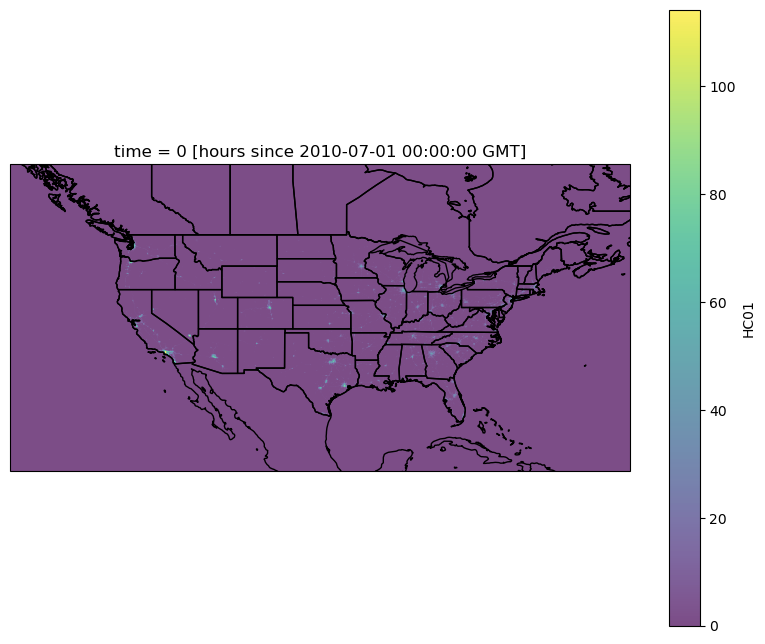

In [21]:
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection = proj)
day_ds[var_name][0,:,:].plot.pcolormesh('lon','lat',ax = ax,alpha=0.7,cmap='viridis')
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
plt.show()